# 뇌졸증 데이터 활용하여 로지스틱 회귀분석해보기

In [10]:
import os 
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time
import seaborn as sns

# Feature 설명
- hypertension : 고혈압 여부
- avg_glucose_level : 혈중 포도당 수치

In [30]:
stroke = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
(stroke['stroke']).value_counts()

0    4861
1     249
Name: stroke, dtype: int64

- 기존 데이터의 결과값으로는 5.12%의 인원이 뇌졸증 환자임.

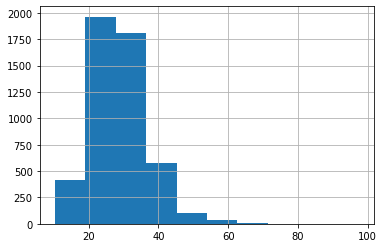

In [6]:
stroke['bmi'].hist()

In [20]:
stroke.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [31]:
# 의미 없는 변수 제거
stroke_p = stroke.dropna().drop(['id', 'work_type', 'Residence_type', 'ever_married'], axis=1, inplace=False)
stroke_p.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,105.92,32.5,never smoked,1
3,Female,49.0,0,0,171.23,34.4,smokes,1
4,Female,79.0,1,0,174.12,24.0,never smoked,1
5,Male,81.0,0,0,186.21,29.0,formerly smoked,1


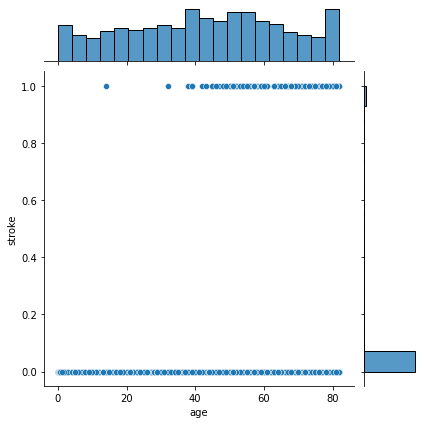

In [13]:
sns.jointplot(x='age', y='stroke', data=stroke_p)

- 뇌졸증 환자는 주로 노년층에 모여있으며, 20대에서도 1개의 결과를 보임.

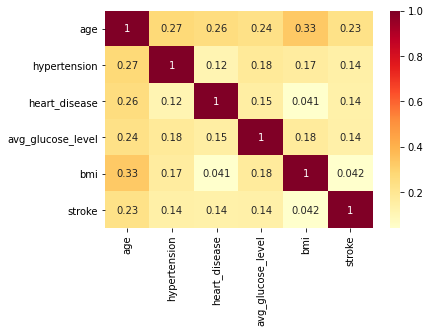

In [14]:
sns.heatmap(stroke_p.corr(), annot=True, cmap='YlOrRd')

In [19]:
stroke_p.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

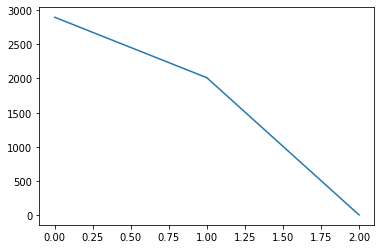

In [36]:
plt.plot(range(len(gend)), gend);

In [32]:
gend = stroke_p['gender'].value_counts()
stroke_p['gender'].value_counts()

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

In [27]:
gend[:2]

Female    2897
Male      2011
Name: gender, dtype: int64

In [33]:
stroke_p['gender'] = stroke_p['gender'].apply(lambda s: s if str(s) not in gend[2:] else 'others' )

In [34]:
stroke_p['gender'].value_counts()

Female    2897
Male      2011
others       1
Name: gender, dtype: int64

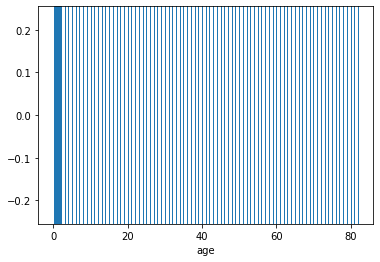

In [38]:
sns.rugplot(x='age', data=stroke_p, height=1);

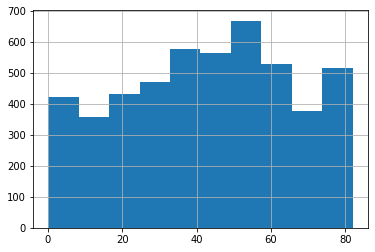

In [41]:
stroke_p['age'].hist();

In [42]:
# 데이터 전처리
stroke_p.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'smoking_status', 'stroke'],
      dtype='object')

In [43]:
stroke_p.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,105.92,32.5,never smoked,1
3,Female,49.0,0,0,171.23,34.4,smokes,1
4,Female,79.0,1,0,174.12,24.0,never smoked,1
5,Male,81.0,0,0,186.21,29.0,formerly smoked,1


In [44]:
X_cat = stroke_p[['gender', 'smoking_status']]
X_cat = pd.get_dummies(X_cat)

In [45]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# StandardScaler 이용해 수치형 데이터 표준화

In [56]:
scaler = StandardScaler()
X_num = stroke_p.drop(['gender', 'smoking_status'], axis=1)

scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns = X_num.columns)

X = pd.concat([X_scaled, X_cat], axis=1)
y = stroke_p['age']

In [57]:
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_others,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.070138,-0.318067,4.381968,2.777698,0.981345,4.742155,0,1,0,0,1,0,0
2,1.646563,-0.318067,4.381968,0.013842,0.459269,4.742155,0,1,0,0,0,1,0
3,0.272012,-0.318067,-0.228208,1.484132,0.701207,4.742155,1,0,0,0,0,0,1
4,1.602222,3.143994,-0.228208,1.549193,-0.623083,4.742155,1,0,0,0,0,1,0
5,1.690903,-0.318067,-0.228208,1.821368,0.013595,4.742155,0,1,0,0,1,0,0


In [48]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [50]:
# Xgboost Regression
from xgboost import XGBRegressor

In [59]:
model_reg = XGBRegressor()
model_reg.fit(X_train, y_train)

[07:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [52]:
# 모델 학습 결과 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [60]:
pred = model_reg.predict(X_test)
print(mean_absolute_error(y_test, pred))
print(sqrt(mean_squared_error(y_test, pred)))

0.01134289636550432
0.0183508133749724


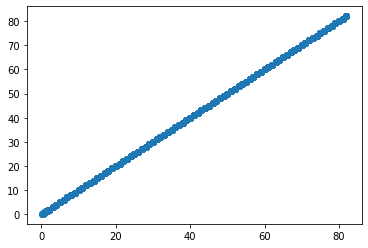

In [61]:
plt.scatter(x=y_test, y=pred)
#plt.plot([0, 350], [0, 350], 'r-');